# Springboard Capstone 2: Tweet Sentiment Extraction

## Data Cleaning and EDA

Original Competition and Dataset Link : https://www.kaggle.com/c/tweet-sentiment-extraction/data

    Author : Pavan Poosarla; 
    Contact : pavanpoosarla01@gmail.com;
    Date : April, 2020;

In [3]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk


In [4]:
def extract_url(tweet):
    url_list = re.findall(r'(https?://\S+)', s)

In [5]:
# Read data into memory
training_fn = r'../data/raw/train.csv'
test_fn = r'../data/raw/test.csv'

In [6]:
train_df = pd.read_csv(training_fn, index_col = 'textID')
test_df = pd.read_csv(test_fn, index_col = 'textID')

In [7]:
train_df.head(3)

,text,selected_text,sentiment
textID,,,
cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
088c60f138,my boss is bullying me...,bullying me,negative


Let us create new adtaframe which can be used for feature extraction and data exploration

In [8]:
print ('Number of rows in dataset is:', train_df.shape[0])

Number of rows in dataset is: 27481


In [9]:
# Basic description of dataset
train_df.describe()

,text,selected_text,sentiment
count,27480,27480,27481
unique,27480,22463,3
top,http://tinyurl.com/nqudrt - Hurt my finger at ...,good,neutral
freq,1,199,11118


As we can see, selected text column does not have too many common entries for us to be able treat the problem as a classification

In [10]:
# Look at the distribution of sentiments
train_df.groupby("sentiment").count()

,text,selected_text
sentiment,,
negative,7781,7781
neutral,11117,11117
positive,8582,8582


Text(0.5, 1.0, 'Counts of the number of tweets by sentiment')

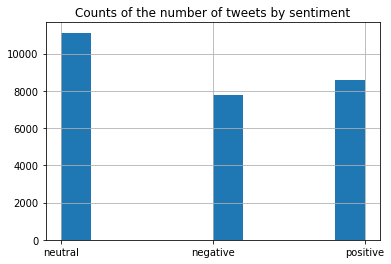

In [11]:
train_df.sentiment.hist()
plt.title('Counts of the number of tweets by sentiment')

Dataset seems to have more neutral tweets. We will try to take this into consideration during modelling

## Look for Missing Values and remove them

In [12]:
def drop_missing_rows(df_in):
    df_in.dropna(axis = 0, inplace = True)
    return df_in  

In [13]:
# Look for missing values
train_df.isna().sum()

text             1
selected_text    1
sentiment        0
dtype: int64

In [14]:
test_df.isna().sum()

text         0
sentiment    0
dtype: int64

In [15]:
df_train_nona = drop_missing_rows(train_df)

In [16]:
df_train_nona.shape

(27480, 3)

## Data Wrangling

Lets look at the texts themselves

In [17]:
def text_preprocess(text):
    # Strip leading and lagging whitespace
    text = text.strip()
    
    # Remove accented characters
#     text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Convert all text to lower case
    text.lower()
    
    # Take raw text and remove all audience reactions
#     text = re.sub('\((.*?)\)', '', text)

    # Remove url's from the tweets.
    text = re.sub(r'(https?://\S+)', '', text)
    
    # Expand Contactions
    # Specific
    """text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    """
    # Remove Punctuation
    """pattern = r'[^a-zA-z\s]'
    text = re.sub(pattern, ' ', text)
    """
#     # Word Lemmatization
#     wnl = WordNetLemmatizer()
    
#     nlp = spacy.load('en_core_web_sm', parse=True, tag=True, entity=True)
#     text = nlp(text)
#     text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    
    return text

In [18]:
def word_count(text):
    wd_list = re.findall('\S+', text)
    return len(wd_list)

In [19]:
def sen_count(text):
    sen_ls = re.split(r'[.!?]+', text)
    sen_ls = [sen for sen in sen_ls if sen !='']
    return len(sen_ls)

In [20]:
def extract_url(text):
    url_ls = re.findall(r'(https?://\S+)', text)
    return url_ls

In [21]:
def jaccard(str1, str2): 
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    jaccard_score = float(len(c)) / (len(a) + len(b) - len(c))
    return jaccard_score
vec_jaccard = np.vectorize(jaccard)

In [50]:
def cleandata(df_raw):
    df_clean = df_raw
    df_clean['clean_text'] = df_clean.text.apply(text_preprocess)
    df_clean['word_count'] = df_clean.clean_text.apply(word_count)
    df_clean['selected_word_count'] = df_clean.selected_text.apply(word_count)
    df_clean['word_count_raw'] = df_clean.text.apply(word_count)
    df_clean['sen_count'] = df_clean.clean_text.apply(sen_count)
    df_clean['char_count'] = df_clean.clean_text.str.len()
    df_clean['url_list'] = df_clean.text.apply(extract_url)
    if 'selected_text' in df_clean.columns:
        df_clean['jaccard'] = (vec_jaccard(df_clean.text, df_clean.selected_text))
    
    return df_clean
    

In [51]:
train_clean = cleandata(df_train_nona)

In [24]:
train_clean.head(3)

,text,selected_text,sentiment,clean_text,word_count,sen_count,char_count,url_list,jaccard
textID,,,,,,,,,
cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,"I`d have responded, if I were going",7,1,35,[],1.000000
549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,Sooo SAD I will miss you here in San Diego!!!,10,1,45,[],0.200000
088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me...,5,1,25,[],0.166667


In [25]:
test_clean = cleandata(test_df)

In [26]:
test_clean.head()

,text,sentiment,clean_text,word_count,sen_count,char_count,url_list
textID,,,,,,,
f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,Last session of the day,5,1,25,[http://twitpic.com/67ezh]
96d74cb729,Shanghai is also really exciting (precisely -...,positive,Shanghai is also really exciting (precisely --...,15,2,102,[]
eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,"Recession hit Veronique Branquinho, she has to...",13,1,78,[]
01082688c6,happy bday!,positive,happy bday!,2,1,11,[]
33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,- I like it!!,4,1,14,[http://twitpic.com/4w75p]


## Exploratory Data Analysis

Plotting histograms of the test and train set, we see that both of the groups have class-imbalance. We have more neutral tweets than either positive or negative

Text(0.5, 1.0, 'Testing Data')

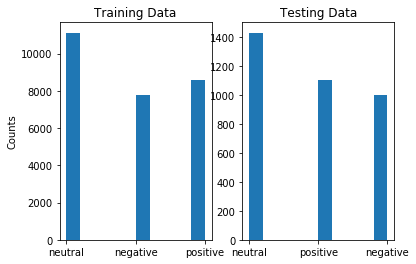

In [27]:
# Plot class distributions
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(train_df.sentiment)
ax1.set_ylabel('Counts')
ax1.set_title('Training Data')
ax2.hist(test_df.sentiment)
ax2.set_title('Testing Data')
# ax2.set_ylabel('Counts')

Lets look at the distribution of character lengths in tweets and slected texts 

Text(0.5, 1.0, 'Distribution of charcater lengths in text')

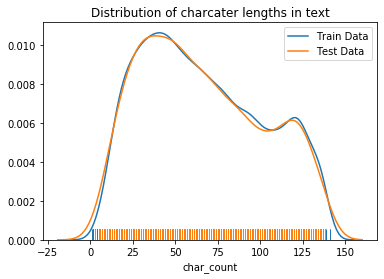

In [28]:
fig, ax = plt.subplots(1,1)
sns.distplot(train_clean.char_count, hist = False, bins = 15, rug = True, ax = ax, label = 'Train Data')
sns.distplot(test_clean.char_count, hist = False, bins = 15, rug = True, ax = ax, label = 'Test Data')
plt.title('Distribution of charcater lengths in text')

We also see that character counts do not have any dependence on the sentiment

Text(0.5, 1.0, 'Distribution of character counts by sentiment in tweets')

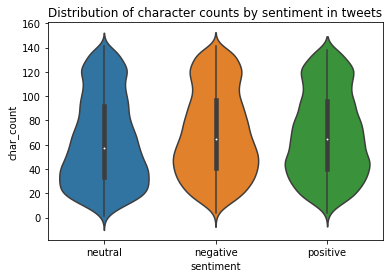

In [29]:
sns.violinplot(y = 'char_count', x = 'sentiment', data = train_clean)
plt.title('Distribution of character counts by sentiment in tweets')

Lets look at the character distribution in the selected text. It appears that the distribution of character length in selected text is wider for netral sentiment compared to either positive or negative

In [30]:
train_clean['selected_char_count'] = train_clean.selected_text.str.len()

Text(0.5, 1.0, 'Character counts by sentiment in selected_text')

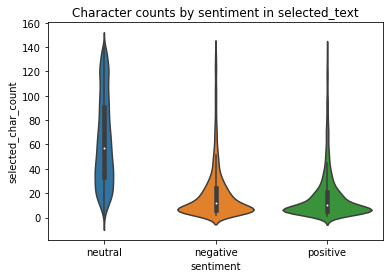

In [31]:
sns.violinplot(y = 'selected_char_count', x = 'sentiment', data = train_clean)
plt.title('Character counts by sentiment in selected_text')

Lets explore this further. Looks like while for positive and negative ratings, the selected text is always smaller than full tweet. But for neutral ratings, there seems to be a section where length of actual and selected text is same


Text(0.5, 1.0, 'Character counts of selected text vs cleaned text')

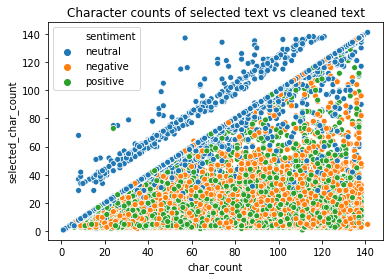

In [32]:
sns.scatterplot(x = 'char_count', y = 'selected_char_count', hue = 'sentiment', data = train_clean)
plt.title('Character counts of selected text vs cleaned text')

This also shows many tweets with slected text having more characters than clean text. Lets dig deeper into this. This may call for changing the text cleaning procedure

In [33]:
train_clean[train_clean.selected_char_count > train_clean.char_count].head(5)

,text,selected_text,sentiment,clean_text,word_count,sen_count,char_count,url_list,jaccard,selected_char_count
textID,,,,,,,,,,
28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,- some shameless plugging for the best Ranger...,11,1,62,[http://www.dothebouncy.com/smf],1.0,92
a3ae670885,Then you should check out http://twittersucks...,Then you should check out http://twittersucks....,neutral,Then you should check out and connect with ot...,13,1,74,[http://twittersucks.com],1.0,97
2dcd8766a8,yellow for ? http://blip.fm/~5z05g,yellow for ? http://blip.fm/~5z05g,neutral,yellow for ?,3,2,15,[http://blip.fm/~5z05g],1.0,36
251aa82551,Here are 4 FREE twitter tools will get you fol...,Here are 4 FREE twitter tools will get you fol...,neutral,Here are 4 FREE twitter tools will get you fol...,10,1,57,"[http://short.to/511q, http://jijr.com/hulz, h...",1.0,137
c20cb786c4,"It`s a Peter & Gordon morning -> And I, go to...","It`s a Peter & Gordon morning -> And I, go to...",neutral,"It`s a Peter & Gordon morning -> And I, go to...",27,3,115,[http://blip.fm/~5yk38],1.0,136


It appears that the url's are not removed from text of the tweet before training the model. We will need to train our actual model without removing urls

Lets replot the above graph with the character counts extracted without cleaning the text. 

In [35]:
train_clean['char_count_raw'] = train_clean.text.str.len()

Text(0.5, 1.0, 'Character counts of selected text vs raw text (before cleaning)')

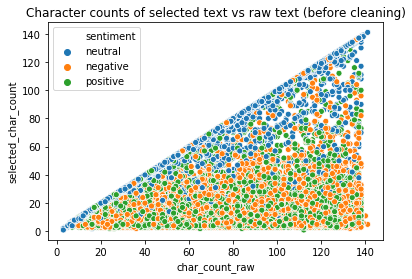

In [36]:
sns.scatterplot(x = 'char_count_raw', y = 'selected_char_count', hue = 'sentiment', data = train_clean)
plt.title('Character counts of selected text vs raw text (before cleaning)')

Text(0.5, 1.0, 'Word counts by sentiment in selected_text')

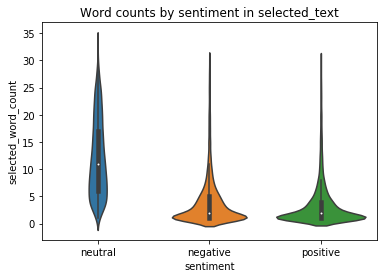

In [55]:
sns.violinplot(y = 'selected_word_count', x = 'sentiment', data = train_clean)
plt.title('Word counts by sentiment in selected_text')

Similar to the distribution of the character counts, lets also look at the distribution of the word counts as the evaluation metric in our case is the word-wise jaccard score

Text(0.5, 1.0, 'Word counts of selected text vs raw text (before cleaning)')

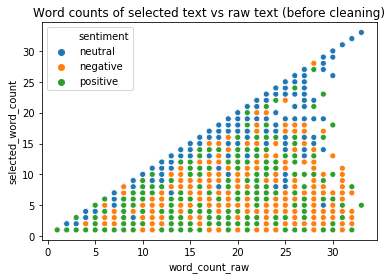

In [53]:
sns.scatterplot(x = 'word_count_raw', y = 'selected_word_count', hue = 'sentiment', data = train_clean)
plt.title('Word counts of selected text vs raw text (before cleaning)')

Lets look at the distribution of the jaccard scores between the sets. 
The distribution tells us that for most of neutral tweets, the selected text is often the entire text of the tweet. 

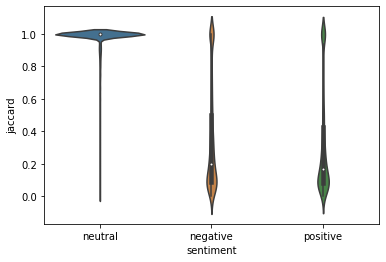

In [37]:
sns.violinplot(y = 'jaccard', x = 'sentiment', data = train_clean, saturation = 0.5)

Lets plot the jaccard by length of the tweets.
Looking at the jaccard scores, it appears that there are tweets with jacacrd score of zero in all of the categories. This is because in some cases of the training set, the selected text is not a complete word in the training set. We need to make sure the selected text has full words in the selected text

This tells us that during prediction, we need to make sure that we treat cases where selected text has different word endings than base text differently


Text(0.5, 1.0, 'Distribution of Jaccard Scores for different sentiment')

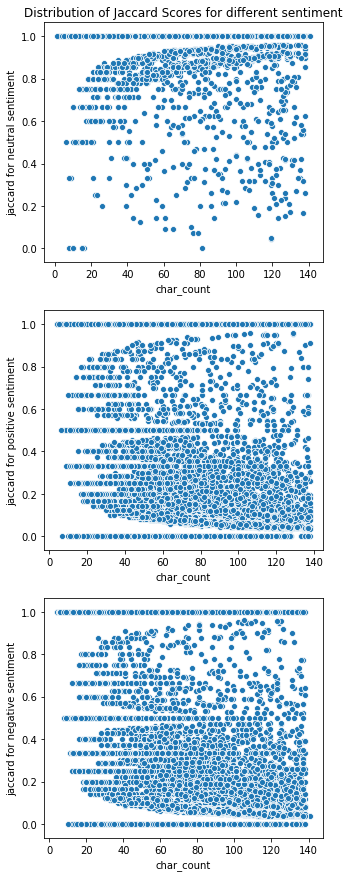

In [38]:
fig, ax = plt.subplots(3, figsize = (5, 15))
sns.scatterplot(x = 'char_count', y = 'jaccard', data = train_clean[train_clean.sentiment == 'neutral'], ax = ax[0])
sns.scatterplot(x = 'char_count', y = 'jaccard', data = train_clean[train_clean.sentiment == 'positive'], ax = ax[1])
sns.scatterplot(x = 'char_count', y = 'jaccard', data = train_clean[train_clean.sentiment == 'negative'], ax = ax[2])
ax[0].set_ylabel('jaccard for neutral sentiment')
ax[1].set_ylabel('jaccard for positive sentiment')
ax[2].set_ylabel('jaccard for negative sentiment')
ax[0].set_title('Distribution of Jaccard Scores for different sentiment')

In [39]:
jaccard_0_df = train_clean[train_clean.jaccard == 0]

In [40]:
jaccard_0_df.head(3)

,text,selected_text,sentiment,clean_text,word_count,sen_count,char_count,url_list,jaccard,selected_char_count,char_count_raw
textID,,,,,,,,,,,
af3fed7fc3,is back home now gonna miss every one,onna,negative,is back home now gonna miss every one,8,1,42,[],0.0,4,42
98f25bc596,mannnn..... _ got an iphone!!! im jealous.... ...,jealous..,negative,mannnn..... _ got an iphone!!! im jealous....,7,4,47,[http://bit.ly/NgnaR],0.0,9,66
95e12b1cb1,He`s awesome... Have you worked with him bef...,s awesome,positive,He`s awesome... Have you worked with him befor...,12,3,68,[],0.0,9,70


In [41]:
jaccard_0_df.to_csv(r'../data/interim/jaccard0data.csv')

Lets look at most prominent words in each sentiment

In [42]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [43]:
STOPWORDS = STOPWORDS.union({'now', 'day', 'today'})

In [44]:
neutral_text = train_clean[train_clean.sentiment == 'neutral'].text
positive_text = train_clean[train_clean.sentiment == 'positive'].text
negative_text = train_clean[train_clean.sentiment == 'negative'].text

In [45]:
def show_wordcloud(df_text_col, title_str):
    text_concatenated = ' '.join(df_text_col)
    wordcloud = WordCloud(max_words = 50, background_color = "white", stopwords = STOPWORDS).generate(text_concatenated)
    plt.figure(figsize = (10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title (title_str)
    plt.show()
    return

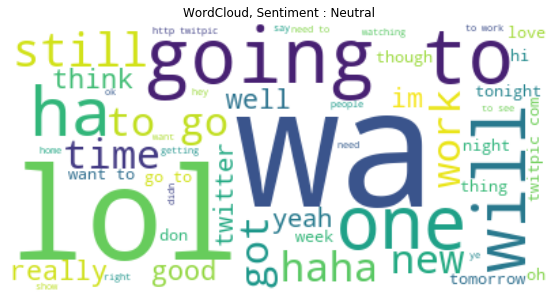

In [46]:
show_wordcloud(neutral_text, 'WordCloud, Sentiment : Neutral')

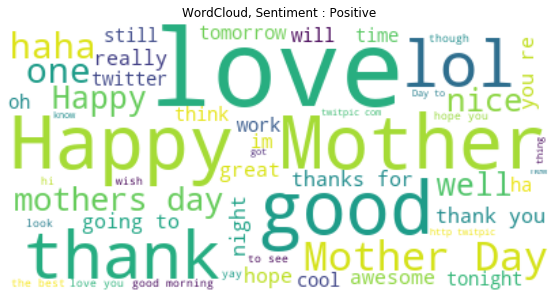

In [47]:
show_wordcloud(positive_text, 'WordCloud, Sentiment : Positive')

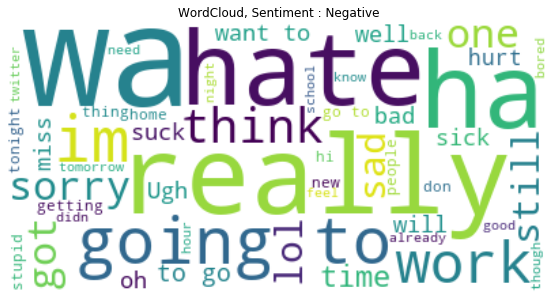

In [48]:
show_wordcloud(negative_text, 'WordCloud, Sentiment : Negative')